In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xgboost

from functions import make_dataset

from functions import make_portfolio

from sklearn.utils import shuffle

import time

import pickle

In [17]:
from pympler import asizeof

In [2]:
start = time.perf_counter()
features2 = pd.read_pickle("training_sets/features2")
print(time.perf_counter() - start)

2.2035158000000004


In [3]:
Date1 = np.load("training_sets/Date1.npy", allow_pickle = True)
Date2 = np.load("training_sets/Date2.npy", allow_pickle = True)
Date3 = np.load("training_sets/Date3.npy", allow_pickle = True)

In [4]:
Dates = np.append(Date1, np.append(Date2, Date3))

In [4]:
def make_dataset_eval_with_extra_return_40_term_from_periods(df, training_period, prediction_period, cols, pred_col, return_col):
    
    
    X_train = shuffle(df.loc[training_period, np.append(cols, pred_col)])
    X_train = X_train.replace([np.inf, -np.inf], np.NaN)
    X_train = X_train.dropna(axis = 0)

    Y_train = X_train.pop(pred_col)
    
    
    
    X_test = shuffle(df.loc[prediction_period, np.append(cols, return_col)])
    X_test = X_test.replace([np.inf, -np.inf], np.NaN)
    X_test = X_test.dropna(axis = 0)
    
    Y_return_40 = X_test.pop(return_col)
    
    return X_train, X_test, Y_train, Y_return_40

In [5]:
def make_dataset_eval_with_extra_return_40_term_from_periods_for_regression(df, training_period, prediction_period, cols, return_col):
    
    
    X_train = shuffle(df.loc[training_period, np.append(cols, return_col)])
    X_train = X_train.replace([np.inf, -np.inf], np.NaN)
    X_train = X_train.dropna(axis = 0)

    Y_train_return_40 = X_train.pop(return_col)
    
    
    
    X_test = shuffle(df.loc[prediction_period, np.append(cols, return_col)])
    X_test = X_test.replace([np.inf, -np.inf], np.NaN)
    X_test = X_test.dropna(axis = 0)
    
    Y_test_return_40 = X_test.pop(return_col)
    
    return X_train, X_test, Y_train_return_40, Y_test_return_40

In [5]:
def return_40_metric(pred, labels):


    return np.mean(labels[np.argsort(pred)[:500]]), (1-np.sort(pred)[499]), np.mean(labels[np.argsort(pred)[:100]]), (1-np.sort(pred)[99]), np.mean(labels[np.argsort(pred)[:20]]), (1-np.sort(pred)[19])

In [6]:
class my_callback(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        
        
    def after_iteration(self, model, epoch, evals_log):
            

        predictions_eval = model.predict(self.eval_mine)

        self.results_eval_mine.append(return_40_metric(model.predict(self.eval_mine), self.eval_return_40))    
        
                 
            
        return False

In [79]:
def return_40_metric_for_regression(pred, labels):


    return np.mean(labels[np.argsort(pred)[-500:]]), np.sort(pred)[-500], np.mean(labels[np.argsort(pred)[-100:]]), np.sort(pred)[-100], np.mean(labels[np.argsort(pred)[-20:]]), np.sort(pred)[-20]

In [190]:
Y_train_return_40.values

TypeError: 'numpy.ndarray' object is not callable

In [6]:
def return_40_metric_for_regression_full(pred, labels):


    return labels[np.argsort(pred)[-500:]].values.astype("float16"), np.sort(pred)[-500:].astype("float32"), labels[np.argsort(pred)[-100:]].values.astype("float16"), np.sort(pred)[-100:].astype("float32"), labels[np.argsort(pred)[-20:]].values.astype("float16"), np.sort(pred)[-20:].astype("float32")

In [81]:
class my_callback_regression(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        
        
    def after_iteration(self, model, epoch, evals_log):
            

        predictions_eval = model.predict(self.eval_mine)

        self.results_eval_mine.append(return_40_metric_for_regression(model.predict(self.eval_mine), self.eval_return_40))    
        
                   
        return False

In [136]:
Y_train_return_40.values

array([ -5.97609562,   6.85483871,   2.18978102, ...,   9.35910478,
       -15.17857143, -18.89153754])

In [7]:
class my_callback_regression2(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        
        
    def after_iteration(self, model, epoch, evals_log):
        
        if not epoch %3:
            

            predictions_eval = model.predict(self.eval_mine)

            self.results_eval_mine.append(return_40_metric_for_regression_full(model.predict(self.eval_mine), self.eval_return_40))    
        
                   
        return False

In [7]:
params1 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  'objective': 'binary:logistic',
  'subsample': 0.9,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0
}

In [105]:
params2 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  'objective': 'reg:squarederror',
  'subsample': 0.9,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0
}

In [8]:
params3 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  'objective': 'reg:squarederror',
  'subsample': 0.9,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0,
    "gamma" : 100000
}

In [ ]:
"where_highest_corr_binary_highest_return_cols_100"

In [8]:
with open("ColSearch2/where_highest_corr_binary_highest_return_cols_20", "rb") as f:
    highest_corr_binary_20 = pickle.load(f)

In [9]:
with open("ColSearch2/where_highest_corr_binary_highest_return_cols_100", "rb") as f:
    highest_corr_binary_100 = pickle.load(f)

In [9]:
with open("ColSearch2/where_highest_corr_reg_highest_return_cols_20", "rb") as f:
    highest_corr_binary_20 = pickle.load(f)

In [10]:
with open("ColSearch2/where_highest_corr_reg_highest_return_cols_100", "rb") as f:
    highest_corr_binary_100 = pickle.load(f)

In [11]:
to_remove_indx = []
for i in highest_corr_binary_20:
    for indx, j in enumerate(highest_corr_binary_100):
        
        try:
            if np.sum(i != j) == 0:
                to_remove_indx.append(indx)
                
                print(i)
            
        except:
            continue
            
for i in np.sort(to_remove_indx)[::-1]:
    del highest_corr_binary_100[i]


['Current Ratio' 'Operating Income (Loss)_QC' 'APO_10_40'
 'close_10/Close_40' 'BOL_indicator_80'
 'Property, Plant & Equipment, Net_QC' 'close_240/Close_320'
 'Operating Income (Loss)/Interest Expense, Net_YC' 'close_20/Close_120'
 'close_0/Close_160' 'Price to Sales Ratio (quarterly)' 'Total Assets_QC'
 'ATR_80' 'ATR_160' 'close_0/Close_240' 'ADX_4_11' 'volatility_80'
 'close_0/Close_40' 'volatility_40' 'CMO_120']


In [11]:
with open("ColSearch2/where_lowest_corr_binary_highest_return_cols_20", "rb") as f:
    lowest_corr_binary_20 = pickle.load(f)

In [12]:
with open("ColSearch2/where_lowest_corr_binary_highest_return_cols_100", "rb") as f:
    lowest_corr_binary_100 = pickle.load(f)

In [12]:
with open("ColSearch2/where_lowest_corr_reg_highest_return_cols_20", "rb") as f:
    lowest_corr_binary_20 = pickle.load(f)

In [13]:
with open("ColSearch2/where_lowest_corr_reg_highest_return_cols_100", "rb") as f:
    lowest_corr_binary_100 = pickle.load(f)

In [14]:
to_remove_indx = []
for i in lowest_corr_binary_20:
    for indx, j in enumerate(lowest_corr_binary_100):
        
        try:
            if np.sum(i != j) == 0:
                to_remove_indx.append(indx)
                
                print(i)
            
        except:
            continue
            
for i in np.sort(to_remove_indx)[::-1]:
    del lowest_corr_binary_100[i]


['volatility_360' 'ATR_20' 'Current Ratio' 'close_80/Close_160'
 'volatility_40' 'Total Assets_YC' 'close_20/Close_120' 'volstd_160']


In [14]:
with open("ColSearch2/where_not_corr_binary_highest_return_cols_20", "rb") as f:
    not_corr_binary_20 = pickle.load(f)

In [15]:
with open("ColSearch2/where_not_corr_binary_highest_return_cols_100", "rb") as f:
    not_corr_binary_100 = pickle.load(f)

In [15]:
with open("ColSearch2/where_not_corr_reg_highest_return_cols_20", "rb") as f:
    not_corr_binary_20 = pickle.load(f)

In [16]:
with open("ColSearch2/where_not_corr_reg_highest_return_cols_100", "rb") as f:
    not_corr_binary_100 = pickle.load(f)

In [17]:
len(not_corr_binary_20), len(not_corr_binary_100)

(10, 1)

In [18]:
to_remove_indx = []
for i in not_corr_binary_20:
    for indx, j in enumerate(not_corr_binary_100):
        
        try:
            if np.sum(i != j) == 0:
                to_remove_indx.append(indx)
                
                print(i)
            
        except:
            continue
            
for i in np.sort(to_remove_indx)[::-1]:
    del not_corr_binary_100[i]

In [17]:
with open("ColSearch2/where_highest_return_binary_cols_20", "rb") as f:
    highest_return_binary_20 = pickle.load(f)

In [18]:
with open("ColSearch2/where_highest_return_binary_cols_100", "rb") as f:
    highest_return_binary_100 = pickle.load(f)

In [9]:
with open("ColSearch2/where_highest_return_reg_cols_20", "rb") as f:
    highest_return_binary_20 = pickle.load(f)

In [10]:
with open("ColSearch2/where_highest_return_reg_cols_100", "rb") as f:
    highest_return_binary_100 = pickle.load(f)

In [11]:
to_remove_indx = []
for i in highest_return_binary_20:
    for indx, j in enumerate(highest_return_binary_100):
        
        try:
            if np.sum(i != j) == 0:
                to_remove_indx.append(indx)
                
                print(i)
            
        except:
            continue
            
for i in np.sort(to_remove_indx)[::-1]:
    del highest_return_binary_100[i]

['Operating Income (Loss)_QC' 'ATR_20' 'volatility_360'
 'close_80/Close_160' 'Property, Plant & Equipment, Net_YC'
 'close_0/Close_160' 'Share Capital & Additional Paid-In Capital'
 'volatility_40' 'close_0/Close_100' 'close_0/Close_40'
 'Price to Sales Ratio (quarterly)' 'volatility_20' 'volstd_40'
 'BOL_indicator_80' 'Net Income_YC' 'Close' 'close_0/Close_130'
 'close_10/Close_320' 'AROON_20' 'DEMA_120'
 'Equity Before Minority Interest/Total Equity_YC' 'close_120/Close_240']
['volatility_20' 'Close' 'Equity Before Minority Interest/Total Equity_YC'
 'close_10/Close_160' 'Property, Plant & Equipment, Net_YC' 'CMO_40'
 'volatility_40' 'DEMA_160' 'Revenue_YC' 'volstd_160'
 'Total Current Liabilities/Total Liabilities_QC' 'close_0/Close_40'
 'close_20/Close_120' 'Price to Book Value_QC' 'close_120/Close_360'
 'ATR_80' 'MFI_80' 'close_240/Close_320' 'volstd_40']
['Total Assets_YC' 'APO_10_20' 'ATR_20' 'volstd_40' 'close_120/Close_360'
 'close_120/Close_240' 'Close' 'volatility_20']
['cl

In [20]:
highest_return_binary_100

[]

In [12]:
prediction_dates = np.linspace(650, len(Dates) - 80, 20).astype(int)

In [13]:
prediction_dates = (prediction_dates + 40)[:-1]

In [14]:
prediction_dates = (prediction_dates -20)

In [15]:
prediction_dates

array([ 670,  754,  839,  923, 1008, 1092, 1177, 1262, 1346, 1431, 1515,
       1600, 1684, 1769, 1854, 1938, 2023, 2107, 2192])

In [15]:
count = 0
#results_reg = []
results_reg_pruned = []
start_time = time.perf_counter()

#while True:
    
#for cols_trials in [highest_corr_binary_20, highest_corr_binary_100, lowest_corr_binary_20, lowest_corr_binary_100, not_corr_binary_20, not_corr_binary_100, highest_return_binary_20, highest_return_binary_100]:
for cols_trials in [highest_return_binary_20, highest_return_binary_100]:  
    count +=1
    print(str(count))

    if time.perf_counter() - start_time > 3600:
        print("sleeping")
        time.sleep(600)
        start_time = time.perf_counter()

        
        
    unique_cols = np.array([])
    for i in cols_trials:
        unique_cols = np.append(unique_cols, i)

    unique_cols = np.unique(unique_cols)
    
    #unique_cols = np.append(unique_cols, ["Class_binary_40_20", "return_40"])
    unique_cols = np.append(unique_cols, ["return_40"])
    
    #results1_reg = []
    results1_pruned = []
    
    
    for prediction_date in prediction_dates:
        
        
        #results2_reg = []
        results2_pruned = []
        
        start_time_df_create = time.perf_counter()
        
        
        training_period = Dates[prediction_date - 200 - 40 + 1: prediction_date - 40 +1]

        prediction_period = Dates[prediction_date :prediction_date + 20 + 1]
        
         
        if len(np.intersect1d(np.append(training_period, prediction_period), Date1)):
        
            if "features1" not in locals():

                features1 = pd.read_pickle("training_sets/features1")   
                
                print("imported features1")

            Date1_intersect = np.intersect1d(np.append(training_period, prediction_period), Date1)

            X_train_master = features1.loc[Date1_intersect, unique_cols]
            

        else:

            if "features1" in locals():
                del features1
                
                print("deleted features1")


        if len(np.intersect1d(np.append(training_period, prediction_period), Date2)):
            
            if "features2" not in locals():

                features2 = pd.read_pickle("training_sets/features2")
                
                print("imported features2")
                
            Date2_intersect = np.intersect1d(np.append(training_period, prediction_period), Date2)
                
            if "X_train_master" in locals():
                
                X_train_master = X_train_master.append(features2.loc[Date2_intersect, unique_cols])
                
            else:
                
                X_train_master = features2.loc[Date2_intersect, unique_cols]
                
        else:

            if "features2" in locals():
                del features2
                
                print("deleted features2")


        if len(np.intersect1d(np.append(training_period, prediction_period), Date3)):

            if "features3" not in locals():

                features3 = pd.read_pickle("training_sets/features3")
                
                print("imported features3")
                
                
            Date3_intersect = np.intersect1d(np.append(training_period, prediction_period), Date3)
                
            if "X_train_master" in locals():
                
                X_train_master = X_train_master.append(features3.loc[Date3_intersect, unique_cols])
                
            else:
                
                X_train_master = features3.loc[Date3_intersect, unique_cols]

        else:

            if "features3" in locals():
                del features3
                
                print("deleted features3")
                
                
        print("df_create_time: "+ str(time.perf_counter() - start_time_df_create))
        
        start_time_cols = time.perf_counter()
        
        for col_indx, cols in enumerate(cols_trials):

        
            #results3_reg = []
            results3_pruned = []

            #X_train, X_test, Y_train, Y_return_40 = make_dataset_eval_with_extra_return_40_term_from_periods(X_train_master, training_period, prediction_period, cols, "Class_binary_40_20", "return_40")

            #train_weights = Y_train.map({0:19, 1:1})

            #xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols, weight = train_weights)

            #xgtest = xgboost.DMatrix(X_test.values, feature_names = cols)

            #data = []

            #mycallback = my_callback(xgtest, Y_return_40, data)

            #bst = xgboost.train(params1, xgtrain, num_boost_round = 120, verbose_eval = False, callbacks = [mycallback])
            
            
            
            X_train, X_test, Y_train_return_40, Y_test_return_40 = make_dataset_eval_with_extra_return_40_term_from_periods_for_regression(X_train_master, training_period, prediction_period, cols, "return_40")

            xgtrain = xgboost.DMatrix(X_train.values, Y_train_return_40.values, feature_names = cols)

            xgtest = xgboost.DMatrix(X_test.values, feature_names = cols)
            
            

            #data = []

            #mycallback = my_callback_regression2(xgtest, Y_test_return_40, data)

            #bst = xgboost.train(params2, xgtrain, num_boost_round = 6, verbose_eval = False, callbacks = [mycallback])
            

            
            #results3_reg.append(str(count) + str(col_indx))
            #results3_reg.append(prediction_date)
            #results3_reg.append(cols)
            #results3_reg.append(data)
            #results3_reg.append(bst.get_score(importance_type='weight'))
            #results3_reg.append(bst.get_score(importance_type='gain'))
            #results3_reg.append(bst.get_score(importance_type='cover'))

            #results2_reg.append(results3_reg)
            


            data = []

            mycallback = my_callback_regression2(xgtest, Y_test_return_40, data)

            bst = xgboost.train(params3, xgtrain, num_boost_round = 120, verbose_eval = False, callbacks = [mycallback])
            

            
            results3_pruned.append(str(count) + str(col_indx))
            results3_pruned.append(prediction_date)
            results3_pruned.append(cols)
            results3_pruned.append(data)
            results3_pruned.append(bst.get_score(importance_type='weight'))
            results3_pruned.append(bst.get_score(importance_type='gain'))
            results3_pruned.append(bst.get_score(importance_type='cover'))

            results2_pruned.append(results3_pruned)
            

            
        #results1_reg.append(results2_reg)
        results1_pruned.append(results2_pruned)
        
        print("10 cols time: " + str(time.perf_counter() - start_time_cols))
            
            
        del X_train_master
        
    #results_reg.append(results1_reg)
    results_reg_pruned.append(results1_pruned)
    
    #with open("ColSearch3/results_regVsPruned_reg.pkl", "wb") as f:
    #    pickle.dump(results_reg, f)
        
    with open("ColSearch3/results_regVsPruned_pruned.pkl", "wb") as f:
        pickle.dump(results_reg_pruned, f)
        
    


1
imported features1
deleted features2
df_create_time: 3.9776847999999987
10 cols time: 137.9439748
imported features2
df_create_time: 4.6152153999999825
10 cols time: 135.78599200000002
df_create_time: 0.49386190000001307
10 cols time: 134.47227070000002
df_create_time: 0.5160558999999694
10 cols time: 137.54995739999998
df_create_time: 0.5069138000000066
10 cols time: 141.12992380000003
deleted features1
df_create_time: 0.607921200000078
10 cols time: 146.87609010000006
df_create_time: 0.4012936000000309
10 cols time: 148.46112859999994
df_create_time: 0.40795989999992344
10 cols time: 147.2785801
df_create_time: 0.42616720000000896
10 cols time: 144.69565999999986
df_create_time: 0.411350400000174
10 cols time: 160.45981669999992
df_create_time: 0.42602160000001277
10 cols time: 162.06858039999997
imported features3
df_create_time: 7.064660999999887
10 cols time: 148.6428201000001
df_create_time: 0.6363589000000047
10 cols time: 147.93679250000014
df_create_time: 0.5509440999999242


In [20]:
with open("ColSearch3/results_regVsPruned_reg.pkl", "rb") as f:
    results_reg = pickle.load(f)

with open("ColSearch3/results_regVsPruned_pruned.pkl", "rb") as f:
    results_reg_pruned = pickle.load(f)

In [ ]:
"""[highest_corr_binary_20, highest_corr_binary_100, lowest_corr_binary_20, lowest_corr_binary_100, not_corr_binary_20, not_corr_binary_100, highest_return_binary_20]:"""


In [7]:
with open("ColSearch3/results_reg.pkl", "rb") as f:
        results = pickle.load(f)

In [8]:
sp500= pd.read_pickle("External_data/sp500")

In [9]:
prediction_dates

array([ 690,  774,  859,  943, 1028, 1112, 1197, 1282, 1366, 1451, 1535,
       1620, 1704, 1789, 1874, 1958, 2043, 2127, 2212])

In [10]:
sp500_return = []
for i in prediction_dates:
    sp500_return.append(np.mean(sp500.loc[Dates[i : i+20], "return_40"]))
    
    

In [25]:
results_reg_parsed = []

for i in results_reg:
    thing = []
    thing2 = []
    
    
    for j in i:
        length = len(j)
        
        for q in j:
            
            thing.append(q)
            
            
    for v in range(length):
        thing2.append(thing[v::length])
        
    results_reg_parsed.append(thing2)


In [17]:
len(results_reg_parsed[1][0])

19

In [26]:
results_reg = results_reg_parsed


In [24]:
results_pruned = results_reg_pruned_parsed

In [20]:
thing = np.array([])
dataset = results_reg


for q in range(len(dataset)):
    for i in dataset[q]:
        for j in i:
            thing = np.append(thing, np.array(j[3])[:,4])
                    

<ipython-input-20-ffc94d4237b0>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  thing = np.append(thing, np.array(j[3])[:,4])


In [205]:
thing = np.array([])



for q in range(len(results_parsed)):
    if q == 6:
        
        for i in results_parsed[q]:
            for indx, j in enumerate(i):
                if indx == 17 or indx == 15 or indx == 6 or indx == 5:
                    continue
                thing = np.append(thing, np.array(j[3])[:,4])

In [70]:
j[3][1]

IndexError: list index out of range

In [34]:
thing = np.array([])

#dataset = results_reg
dataset = results_pruned
for q in range(len(dataset)):
    for i in dataset[q]:
        for j in i:
            
            thing = np.append(thing, [np.mean(np.array(j[3])[:,4][v]) for v in range(40)])

<ipython-input-34-41b73a411cb7>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  thing = np.append(thing, [np.mean(np.array(j[3])[:,4][v]) for v in range(40)])


In [35]:
pruned = np.mean(np.reshape(thing, (-1, 40)), axis = 0)

In [33]:
reg = np.mean(np.reshape(thing, (-1, 40)), axis = 0)

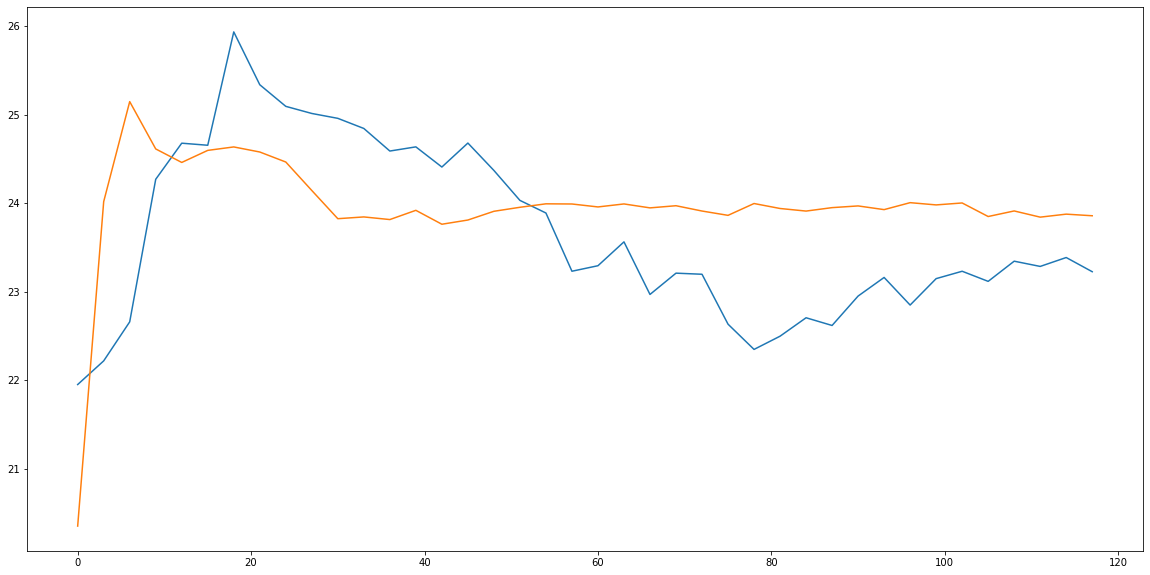

In [36]:
"""
returns vs boosting rounds as a whole

"""
plt.figure(figsize = (20, 10))

#plt.plot(np.mean(np.reshape(thing, (-1, 120)), axis = 0))
plt.plot(np.arange(0, 120)[::3], reg)
plt.plot(np.arange(0, 120)[::3], pruned)

In [43]:
np.arange(0, 120)[::3]

40

In [40]:
q = results_reg[0][0][0]
np.mean([np.mean(q[3][v][0]) for v in range(15, 25)])

4.504

In [43]:
indx

0

In [48]:
np.shape(q)

C:\Users\Chirag\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(10, 19, 7)

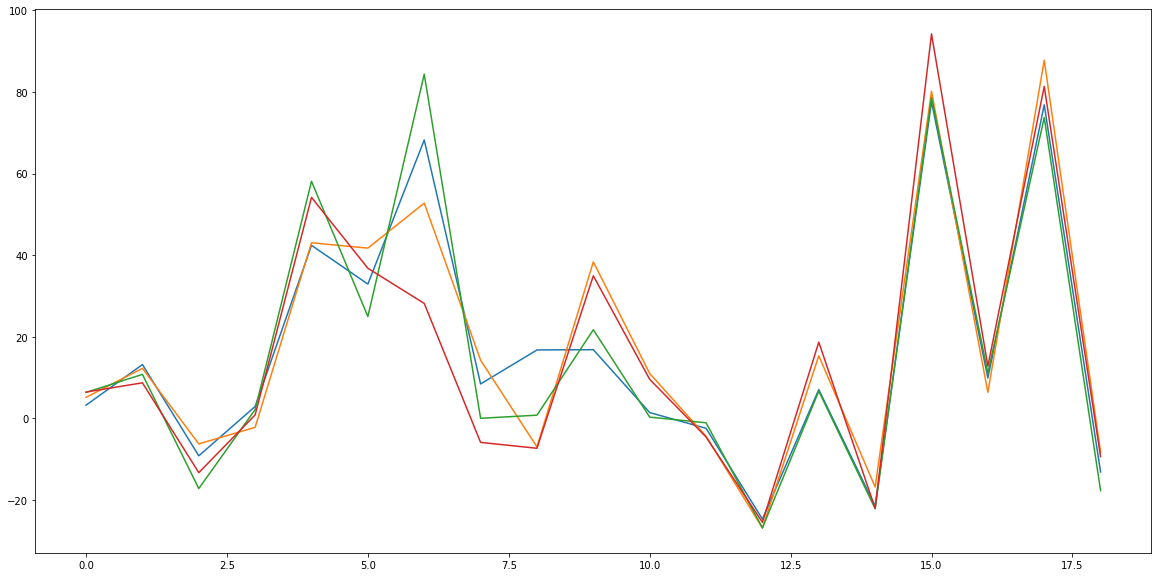

In [57]:
plt.figure(figsize = (20, 10))
plt.ion()

for dataset in [results_pruned, results_reg]:

    for indx, q in enumerate(dataset):
        thing = []

        for _ in range(19):
            thing.append([])

        for i in q:
            for indx2, j in enumerate(i):



                thing_to_append = np.mean([np.mean(j[3][v][2]) for v in range(15, 25)])
                thing[indx2].append(thing_to_append)

        plt.plot(np.mean(thing, axis = 1))
    

In [52]:
thing

[[0.5737, 8.66, 4.39, 3.785],
 [1.1455, 4.26, 11.83, 11.95],
 [-5.11, -0.515, -14.75, -3.979],
 [0.5327, 1.175, 0.591, 0.716],
 [21.28, 29.2, 30.03, 27.2],
 [14.66, 21.5, 23.5, 21.33],
 [15.43, 10.39, 30.39, 26.92],
 [-3.783, 6.31, 7.664, 4.17],
 [1.085, 14.64, 14.82, 4.945],
 [17.23, 1.515, 13.4, 12.445],
 [7.19, -0.01103, 5.89, 1.263],
 [-10.18, 2.518, -3.555, -3.438],
 [-14.2, -28.34, -26.72, -23.25],
 [1.407, 9.75, 10.09, 10.484],
 [-18.52, -20.94, -14.18, -19.05],
 [59.0, 59.4, 58.4, 62.38],
 [14.28, 15.95, 1.929, 2.566],
 [60.38, 62.7, 89.75, 69.56],
 [-8.02, -6.695, -9.97, -11.586]]

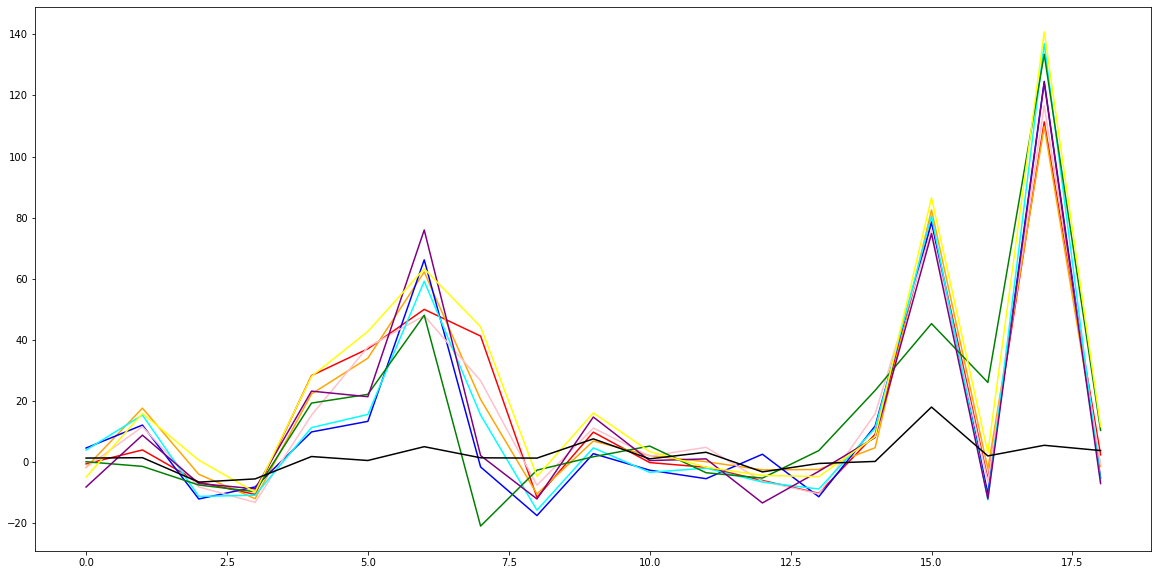

In [24]:
plt.figure(figsize = (20, 10))
plt.ion()
color_list = ["red", "orange", "blue", "pink", "cyan", "green", "purple", "yellow"]
    
for indx_1, i in enumerate(results_parsed):
    thing = []
    for _ in range(19):
        thing.append([])
    
    
    for j in i:
        for indx, q in enumerate(j):
            thing[indx].append(np.mean(np.array(q[3])[35:45,2]))
            
    plt.plot(np.mean(thing, axis = 1), color_list[indx_1])
    
plt.plot(sp500_return, "black")

In [ ]:
plt.figure(figsize = (20, 10))
plt.ion()
    
for i in results_parsed:
    thing = []
    for _ in range(19):
        thing.append([])
    
    
    for j in i:
        for indx, q in enumerate(j):
            thing[indx].append(np.mean(np.array(q[3])[35:45,4]))
            
    plt.plot(np.mean(thing, axis = 1))
    
plt.plot(sp500_return, "black")

In [76]:
thing = np.array([])
for i in results_parsed[1]:
    for j in i:
        thing = np.append(thing, np.mean(np.array(j[3])[40:60,4]))
        
        

In [72]:
"""
high_corr_20
"""
np.corrcoef(np.mean(np.reshape(thing, (-1, 19)),axis = 0), sp500_return)

array([[1.        , 0.57777733],
       [0.57777733, 1.        ]])

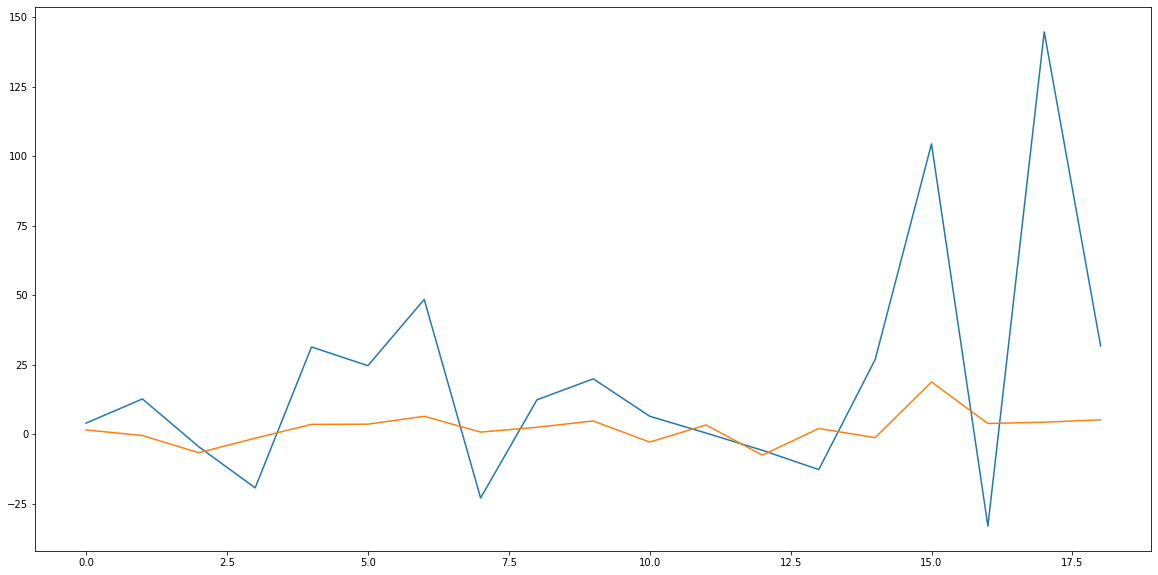

In [71]:
plt.figure(figsize = (20, 10))
plt.plot(np.mean(np.reshape(thing, (-1, 19)),axis = 0))
plt.plot(sp500_return)

In [64]:
      
all_returns = np.array([])
all_returns_thresh = np.array([])

for group in results_parsed[-2:]:
    for col in group:
        for pred_date in col:
            
            all_returns = np.append(all_returns, np.array(pred_date[3])[35:45,0])
            all_returns_thresh = np.append(all_returns_thresh, np.array(pred_date[3])[35:45,1])
        
        
        
        

In [65]:
for num in range(50, 500):
    try:
        splitted_binary = np.split(np.argsort(all_returns_thresh), num)
        #splitted_reg = np.split(np.argsort(all_returns_reg_thresh), num)
        print(num)
        break
        
    except:
        continue

70


In [66]:
np.where(all_returns_thresh 

SyntaxError: unexpected EOF while parsing (<ipython-input-66-171ea956b981>, line 1)

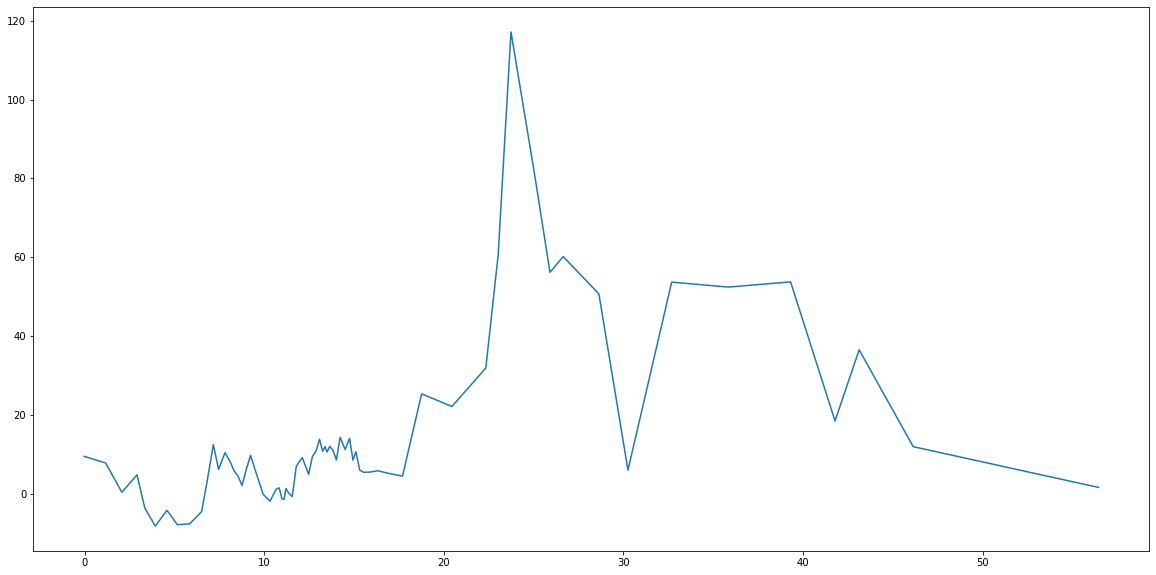

In [67]:
plt.figure(figsize = (20, 10))
plt.plot([np.mean(all_returns_thresh[splitted_binary[i]]) for i in range(num)], [np.mean(all_returns[splitted_binary[i]]) for i in range(num)])
#plt.plot([np.mean(all_returns_reg_thresh[splitted_reg[i]]) for i in range(num)], [np.mean(all_returns_reg[splitted_reg[i]]) for i in range(num)])


In [104]:
thing_mean = np.array([])
thing_std = np.array([])
all_return = np.array([])
for group in results_parsed[:]:
    for col in group:
        for indx, pred_date in enumerate(col):
            if indx == 17 or indx == 15 or indx == 6 or indx == 5:
                continue
            a = list(pred_date[5].values())
   
            
            thing_mean = np.append(thing_mean, np.mean(a))
            all_return = np.append(all_return, np.mean(np.array(pred_date[3])[35:45,4]))
            thing_std = np.append(thing_std, np.std(a))
            
            

In [106]:
np.mean(all_return[np.where(thing_mean > 0.2e7)[0]]), np.mean(all_return[np.where(thing_mean <= 0.2e7)[0]])

(4.83899752206467, -4.196806941168825)

In [94]:
np.std(thing_mean)

1365648.9185271454

(array([577.,  56.,  21.,  48.,  70.,  41.,  14.,   0.,   6.,   6.,   7.,
         11.,  15.,   7.,   2.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   1.,   2.,   2.,
          5.,   2.,   0.,   4.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   3.,   0.,   2.,   0.,   0.,   0.,   3.,   5.,   1.,
          2.,   3.,   0.,   3.,   1.,   0.,   0.,   0.,   0.,   3.,   0.,
          1.,   0.,   0.,   0.,   0., 

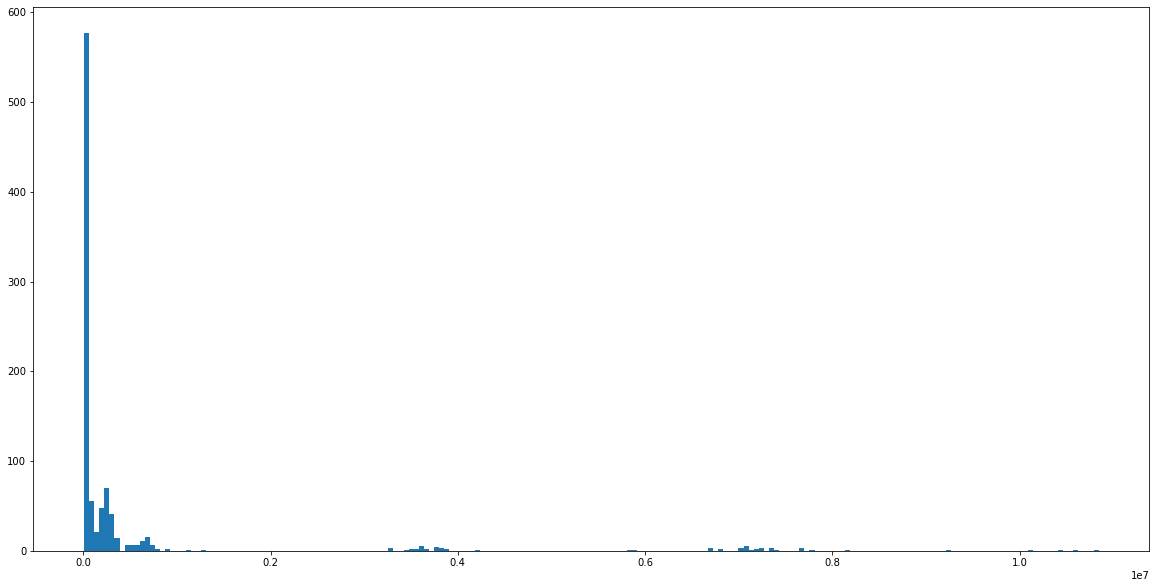

In [105]:
plt.figure(figsize = (20, 10))
plt.hist(thing_mean, bins = 200)

In [90]:
np.mean(thing_mean)

376482.18731337396

In [89]:
len(thing_mean)

266

In [78]:
thing_mean

array([-7.51136210e+00, -1.38746716e+01, -1.41352502e+01, ...,
        2.68146439e+01,  2.68146439e+01,  2.07316993e+05])

In [75]:
np.mean(thing_mean)

16.955493023952332

In [68]:
results_parsed[-1][0][0][5]

{'Price to Book Value_QC': 32349.236328125,
 'CMO_120': 23822.326171875,
 'volatility_160': 39939.52734375,
 'CMO_40': 27905.619140625,
 'close_0/Close_100': 28486.015625,
 'close_120/Close_360': 75984.3671875,
 'Total Assets_YC': 34056.32421875,
 'BOL_indicator_80': 19234.80859375,
 'APO_10_20': 29439.248046875,
 'BOL_indicator_120': 25552.419921875,
 'Cash from (Repurchase of) Equity/Market-Cap': 37406.03515625,
 'volatility_40': 33239.5625,
 'Total Assets_QC': 56235.67578125,
 'Close': 54098.18359375,
 'Share Capital & Additional Paid-In Capital': 55072.98828125,
 'close_0/Close_160': 30518.494140625,
 'Revenue_YC': 30607.138671875,
 'Total Current Assets/Total Assets': 42101.43359375,
 'DEMA_120': 32094.505859375,
 'DEMA_160': 30321.869140625,
 'Property, Plant & Equipment, Net_YC': 32227.994140625,
 'MFI_80': 36832.53125,
 'Property, Plant & Equipment, Net_QC': 46846.44140625,
 'Total Assets/Share Capital & Additional Paid-In Capital': 46208.16796875,
 'ABAND_signal_20': 11389.889